# Multi-Armed Bandit Line Jump

In this notebook, we test our knowledge of multi-armed bandits on the a line wark problem. The formulation of a line walk problem is as follows:
- We have a line scaled from 0 to $\texttt{max\_scale}$.
- We set sample random two variables $\texttt{agent\_position}$ and $\texttt{goal}$ in the line scale. These are:
    - $\texttt{agent\_position}$: our agent position
    - $\texttt{goal}$: our goal position
- We can perfom a jump from a set of n jumps which basically determines how the agent towards to the goal.
- Objective: Find the jump to makes the agent reach the goal (or at least be the closest possible).

### Import

In [1]:
import time
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(int(time.time()))
%matplotlib inline

## Environment

We start by creating the environment which is a fairly simple one.
- We generate the goal and the agent position
- Our reward at a given time step is given by:

$$ P_t = \frac{1}{|\texttt{agent\_positon}_t - \texttt{goal}| + 1}$$

$$

R_t = X \sim \mathrm{Bern}(P_t)
$$

In [2]:
from rl_lab.environments.bandits import LineWalkEnvironment

## Agent

- The only information our greedy agent has is:
    - The set of actions it can perform.
    - The expected gain of each action along over time.
- We update our expected reward for each action according to the following formula.

$$
Q_t(a)=\frac{R_1+R_2+\cdots+R_{N_t(a)}}{N_t(a)}
$$

- To compute it recursively, we use the following formula.

$$
Q_t(a)= Q_{t - 1}(a)+ \frac{1}{N_t(a)} (R_{N_t(a)} - Q_{t - 1}(a))
$$

You can check th code for the used agent at []()

In [3]:
from rl_lab.agents.bandits import GreedyBandit

## Training

Now, let us create the function that runs the different experiments and returns the metrics of interest to compare different methods. We implement these experiments such that $10^{th}$ action is always the best action.

In [4]:
from rl_lab.runners import run_bandits_experiments

The next steps is to run a simulation with different approach to solving the multi-armed bandit problem. These approaches are:
    
- Greedy Solution (only select best action)
- $\epsilon$-greedy (select best action with probability 1 - $\epsilon$)
- The same previous methods but we constant step size instead of the using the reciprocal of the number of times the action for which we obtained a reward was taken.

In [41]:
num_actions = 10
line_length = 256
timesteps = 4000
num_experiments = 100

specs = {
    "$\epsilon=0.1$": {"agent": GreedyBandit, "params": {"epsilon": 0.1}, "color": "black"},
    "$\epsilon=0.01$": {"agent": GreedyBandit, "params": {"epsilon": 0.01}, "color": "red"},
    "$\epsilon=0.0$": {"agent": GreedyBandit, "params": {"epsilon": 0.0}, "color": "green"},
    "$\epsilon=0.1 (constant-step)$": {"agent": GreedyBandit, "params": {"epsilon": 0.01, "step_value": 0.5}, "color": "blue"},
    "$\epsilon=0.01 (constant-step)$": {"agent": GreedyBandit, "params": {"epsilon": 0.001, "step_value": 0.5}, "color": "brown"},
    "$\epsilon=0.0 (constant-step)$": {"agent": GreedyBandit, "params": {"epsilon": 0.0, "step_value": 0.5}, "color": "black"}
}

results = run_bandits_experiments(
    specs, LineWalkEnvironment, timesteps, num_actions, num_experiments, line_length
)

Now we will plot different experiments.

In [42]:
from rl_lab.plotters import plot_lines, plot_bars

<AxesSubplot: title={'center': 'Average reward (per actions) over 100 experiments'}, xlabel='Actions', ylabel='Average Reward'>

<Figure size 640x480 with 0 Axes>

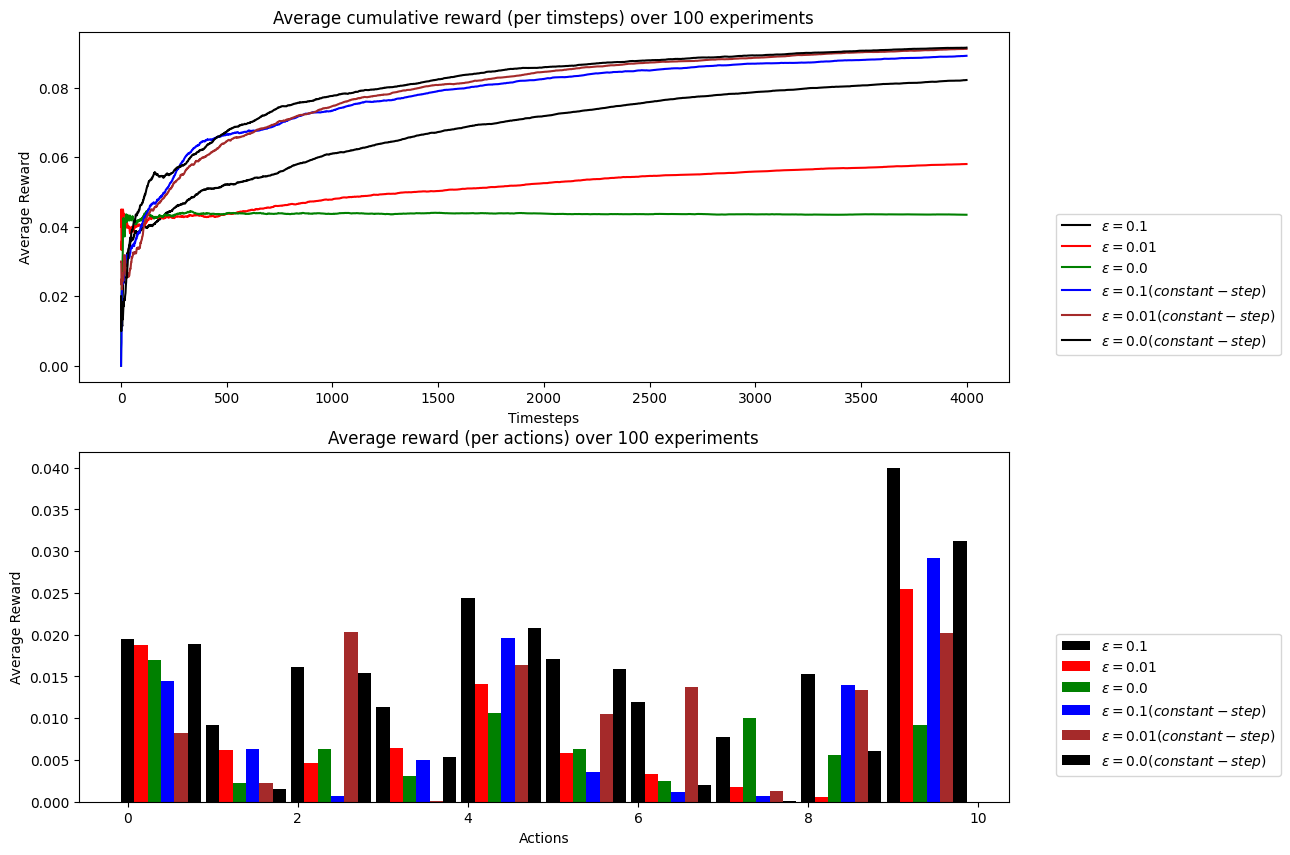

In [43]:
plt.tight_layout(pad=20.0)

fig, ax = plt.subplots(2, 1, figsize=(12, 10))

# average reward per timesteps
plot_lines(
    ax[0],
    results,
    x_values=range(timesteps),
    y_key="timesteps_reward",
    title=f"Average cumulative reward (per timsteps) over {num_experiments} experiments",
    x_label="Timesteps",
    y_label="Average Reward",
)

# Average reward expectation of the model per timesteps
plot_bars(
    ax[1],
    results,
    bins=np.linspace(0, num_actions - 1, num_actions),
    y_key="actions_reward",
    title=f"Average reward (per actions) over {num_experiments} experiments",
    x_label="Actions",
    y_label="Average Reward",
)

Now let us look at UCB bandits the adds an uncertainty value to the expected reward. As a result, the selected action is based on the formula below:

$$
A_t=\underset{a}{\arg \max }\left[Q_t(a)+c \sqrt{\frac{\ln t}{N_t(a)}}\right] \text {, }
$$

The $c$ parameter influences the confidence level because it controls how much uncertainty we allow to influence our choice of the best action.

In [44]:
from rl_lab.agents.bandits import UCBBandit

In [45]:
another_specs = {
    "$c=0.1$": {"agent": UCBBandit, "params": {"c": 1.0, "epsilon": 0.0, "step_value": 0.5}, "color": "black"},
    "$c=0.5$": {"agent": UCBBandit, "params": {"c": 2.0, "epsilon": 0.0, "step_value": 0.5}, "color": "red"},
    "$c=1.0$": {"agent": UCBBandit, "params": {"c": 5.0, "epsilon": 0.0, "step_value": 0.5}, "color": "green"},
}

another_results = run_bandits_experiments(
    another_specs, LineWalkEnvironment, timesteps, num_actions, num_experiments, line_length
)

<AxesSubplot: title={'center': 'Average reward (per actions) over 100 experiments'}, xlabel='Actions', ylabel='Average Reward'>

<Figure size 640x480 with 0 Axes>

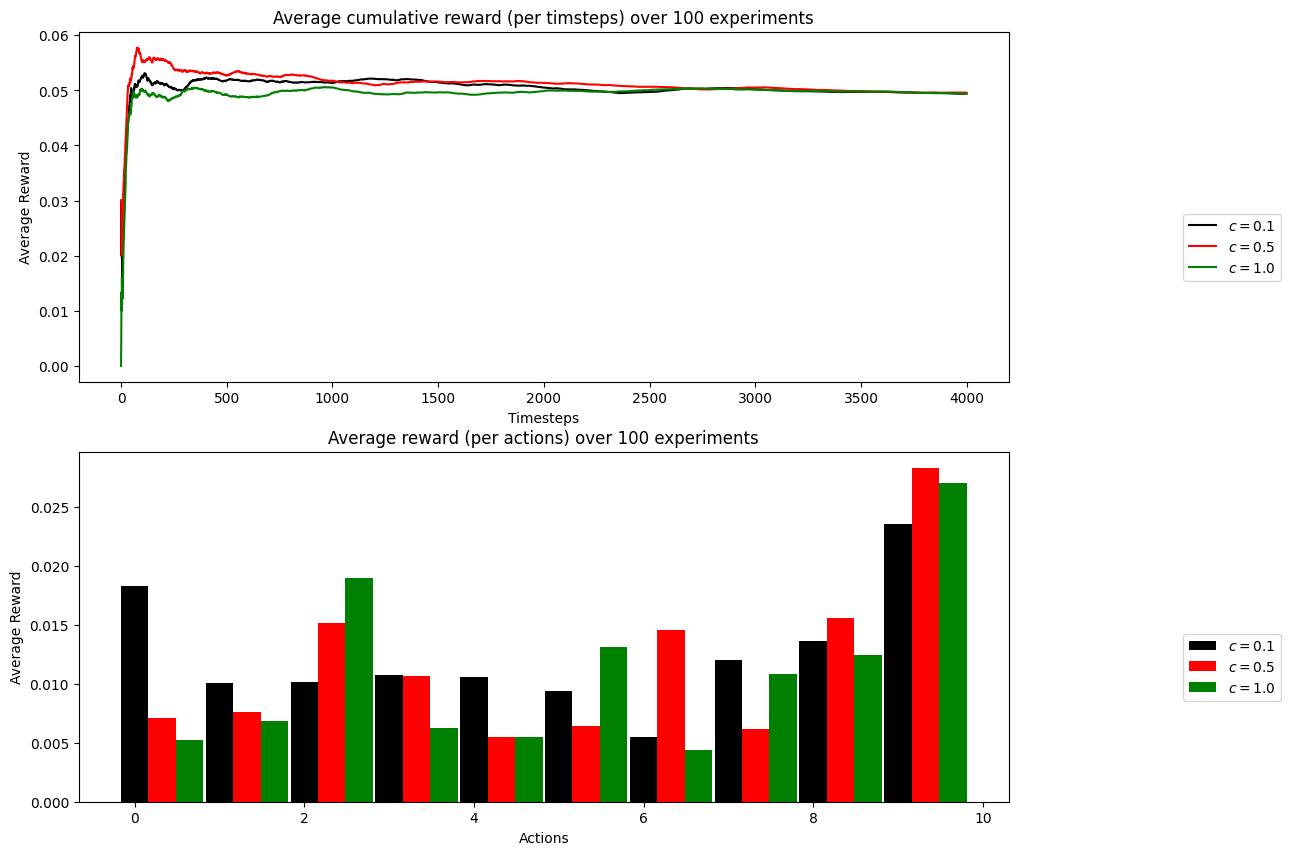

In [46]:
plt.tight_layout(pad=20.0)

fig, ax = plt.subplots(2, 1, figsize=(12, 10))

# average reward per timesteps
plot_lines(
    ax[0],
    another_results,
    x_values=range(timesteps),
    y_key="timesteps_reward",
    title=f"Average cumulative reward (per timsteps) over {num_experiments} experiments",
    x_label="Timesteps",
    y_label="Average Reward",
)

# Average reward expectation of the model per timesteps
plot_bars(
    ax[1],
    another_results,
    bins=np.linspace(0, num_actions - 1, num_actions),
    y_key="actions_reward",
    title=f"Average reward (per actions) over {num_experiments} experiments",
    x_label="Actions",
    y_label="Average Reward",
)

UCB Bandit is worse but can't explain why. :c Code needs to be checked.

Additional, we can look at another type of bandit algorithm called Gradients Bandits. These bandits works with relative preferences rather than reward directly. This done by computing a softmax distribution of preferences $H(a)$.

$$
\operatorname{Pr}\left\{A_t=a\right\}=\frac{e^{\left.H_t(a)\right)}}{\sum_{b=1}^n e^{H_t(b)}}=\pi_t(a)
$$

 Therefore, adding a constant amount to all preferences will not affect the action probabilities. The rules to update the preferences are as follows

$$
\begin{aligned}
H_{t+1}\left(A_t\right) & =H_t\left(A_t\right)+\alpha\left(R_t-\bar{R}_t\right)\left(1-\pi_t\left(A_t\right)\right), & & \text { and } \\
H_{t+1}(a) & =H_t(a)-\alpha\left(R_t-\bar{R}_t\right) \pi_t(a), & & \forall a \neq A_t
\end{aligned}
$$
here $\alpha>0$ is a step-size parameter and \bar{R} is the baseline reward. We can choose any thing that does not depend on the current action selected. We choose the average reward before timestep $t+1$ in this case.

In [47]:
from rl_lab.agents.bandits import GradientsBandit

In [48]:
another_specs2 = {
    "$step value=0.1$": {"agent": GradientsBandit, "params": {"step_value": 0.1}, "color": "black"},
    "$step value=0.5$": {"agent": GradientsBandit, "params": {"step_value": 0.5}, "color": "red"},
    "$step value=1.0$": {"agent": GradientsBandit, "params": {"step_value": 1.0}, "color": "green"},
}

another_results2 = run_bandits_experiments(
    another_specs2, LineWalkEnvironment, timesteps, num_actions, num_experiments, line_length
)

<AxesSubplot: title={'center': 'Average reward (per actions) over 100 experiments'}, xlabel='Actions', ylabel='Average Reward'>

<Figure size 640x480 with 0 Axes>

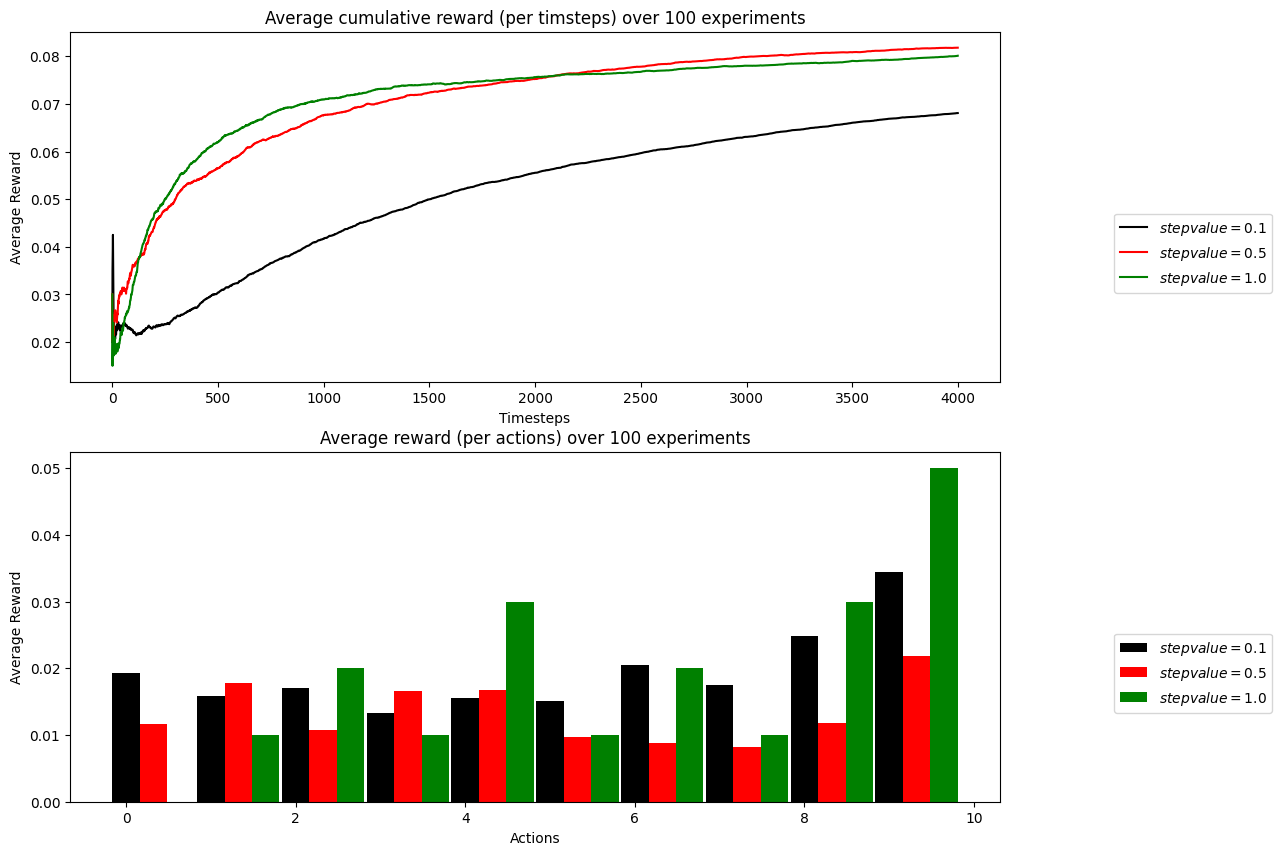

In [49]:
plt.tight_layout(pad=20.0)

fig, ax = plt.subplots(2, 1, figsize=(12, 10))

# average reward per timesteps
plot_lines(
    ax[0],
    another_results2,
    x_values=range(timesteps),
    y_key="timesteps_reward",
    title=f"Average cumulative reward (per timsteps) over {num_experiments} experiments",
    x_label="Timesteps",
    y_label="Average Reward",
)

# Average reward expectation of the model per timesteps
plot_bars(
    ax[1],
    another_results2,
    bins=np.linspace(0, num_actions - 1, num_actions),
    y_key="actions_reward",
    title=f"Average reward (per actions) over {num_experiments} experiments",
    x_label="Actions",
    y_label="Average Reward",
)

Gradient Bandits seems to be outperforming all the previous methods.